<a href="https://colab.research.google.com/github/blantj/car_image_recognition/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [82]:
import os
import shutil
import numpy as np
!pip install split_folders
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.callbacks import EarlyStopping
from keras import models, layers
from keras import optimizers, losses
from keras.applications import DenseNet121, Xception
from tensorflow.keras.models import Model

# Obtain Data

Mount Google Drive

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip car image recognition dataset files

In [ ]:
!tar --gunzip --extract --verbose --file=/content/drive/MyDrive/Car_image_recognition/car_devkit.tgz
!tar --gunzip --extract --verbose --file=/content/drive/MyDrive/Car_image_recognition/cars_test.tgz
!tar --gunzip --extract --verbose --file=/content/drive/MyDrive/Car_image_recognition/cars_train.tgz

# Scrub Data

Split image files into seperate folders for each class


In [85]:
os.mkdir(f'/content/cars_train/pre-split/')
for num in range(1,197):
  os.mkdir(f'/content/cars_train/pre-split/{num}')

annotations = scipy.io.loadmat('/content/devkit/cars_train_annos.mat')['annotations'][0]
for index, annotation in enumerate(annotations):
  im_class = annotation[4][0][0]
  im_name = str(index+1).zfill(5) + '.jpg'
  shutil.move(f'/content/cars_train/{im_name}', f'/content/cars_train/pre-split/{im_class}/{im_name}')


FileExistsError: ignored

Split dataset into train, test and validation folders

In [ ]:
input_folder = '/content/cars_train/pre-split'
output_folder = '/content/cars_train/post-split'

splitfolders.ratio(input_folder, output=output_folder, seed=37, ratio=(.64, .2, .16))

Count number of images in training, test and val sets

In [ ]:
train_folder = '/content/cars_train/post-split/train'
test_folder = '/content/cars_train/post-split/test'
val_folder = '/content/cars_train/post-split/val'

train_imgs = []
test_imgs = []
val_imgs = []


for img_class in range(1,197):
  train_imgs.extend([file for file in os.listdir(train_folder+'/'+str(img_class)) if file.endswith('.jpg')])
  test_imgs.extend([file for file in os.listdir(test_folder+'/'+str(img_class)) if file.endswith('.jpg')])
  val_imgs.extend([file for file in os.listdir(val_folder+'/'+str(img_class)) if file.endswith('.jpg')]) 

train_batch_size = len(train_imgs)
test_batch_size = len(test_imgs)
val_batch_size = len(val_imgs)

print('Train batch size:', train_batch_size)
print('Test batch size:', test_batch_size)
print('Val batch size:', val_batch_size)

Generate image data from .jpg files

In [ ]:
train_generator = ImageDataGenerator().flow_from_directory(
                        train_folder, target_size=(224, 224), batch_size = train_batch_size)

test_generator = ImageDataGenerator().flow_from_directory(
                        test_folder, target_size=(224, 224), batch_size = test_batch_size) 

val_generator = ImageDataGenerator().flow_from_directory(
                        val_folder, target_size=(224, 224), batch_size = val_batch_size) 

Split image data into image and label variables

In [ ]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Explore Data

Calculate shape of train, test and val image sets

In [86]:
print('Train images shape: ', train_images.shape)
print('Test images shape: ', test_images.shape)
print('Val images shape: ', val_images.shape)

Train images shape:  (5108, 224, 224, 3)
Test images shape:  (1490, 224, 224, 3)
Val images shape:  (1546, 224, 224, 3)


Calculate shape of train, test and val labels sets

In [87]:
print('Train labels shape: ', train_labels.shape)
print('Test labels shape: ', test_labels.shape)
print('Val labels shape: ', val_labels.shape)

Train labels shape:  (5108, 196)
Test labels shape:  (1490, 196)
Val labels shape:  (1546, 196)


Calculate class balance

Class
119    68
79     49
161    48
167    48
56     47
       ..
175    31
64     30
158    29
99     28
136    24
Name: index, Length: 196, dtype: int64
Average Class Size 41.55102040816327


[]

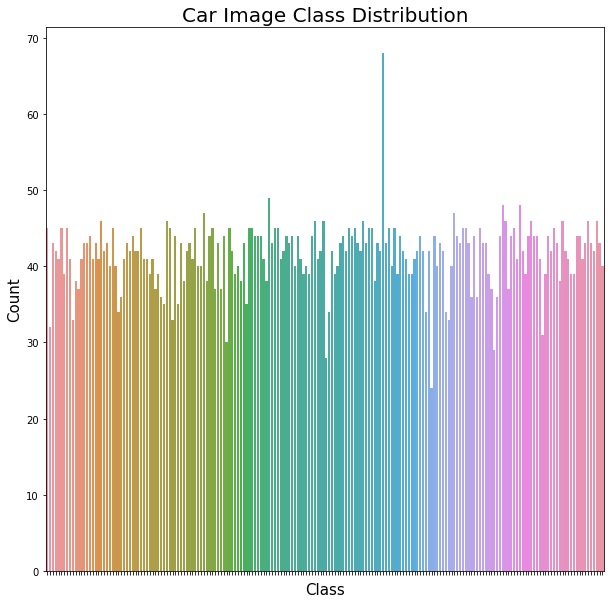

In [88]:
im_classes = []
for image in scipy.io.loadmat('/content/devkit/cars_train_annos.mat')['annotations'][0]:
  im_classes.append(image[4][0][0])
class_df = pd.DataFrame(data=im_classes, columns=['Class'])

print(class_df.reset_index().groupby('Class').count()['index'].sort_values(ascending=False))
print('Average Class Size', (train_batch_size+test_batch_size+val_batch_size)/196)

fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(data=class_df, x='Class', ax=ax)
ax.set_title('Car Image Class Distribution', fontsize=20)
ax.set_xlabel('Class', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_xticklabels(labels=[])

# Model Data

Build neural network in Keras

In [93]:
model = models.Sequential()
model.add(layers.Conv2D(256, (3, 3), activation='relu',
                        input_shape=(224 ,224,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SpatialDropout2D(0.1))

model.add(layers.Conv2D(256, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SpatialDropout2D(0.1))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(196, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Train Keras Neural Network

In [94]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    batch_size=32,
                    validation_data=(test_images, test_labels),
                    callbacks=[es])

Epoch 1/20
160/160 [==============================] - 45s 267ms/step - loss: 113.2184 - acc: 0.0018 - val_loss: 5.2775 - val_acc: 0.0060
Epoch 2/20
160/160 [==============================] - 41s 257ms/step - loss: 5.2783 - acc: 0.0040 - val_loss: 5.2779 - val_acc: 0.0054
Epoch 3/20
160/160 [==============================] - 41s 257ms/step - loss: 5.2753 - acc: 0.0107 - val_loss: 5.2737 - val_acc: 0.0087
Epoch 4/20
160/160 [==============================] - 41s 257ms/step - loss: 5.2111 - acc: 0.0259 - val_loss: 5.3360 - val_acc: 0.0081
Epoch 5/20
160/160 [==============================] - 41s 257ms/step - loss: 5.0480 - acc: 0.0618 - val_loss: 5.4724 - val_acc: 0.0094
Epoch 00005: early stopping


Create DenseNet121 pre-trained transfer learning model

In [ ]:
pre_model = DenseNet121(
    input_shape=train_images.shape[1:],
    include_top=False,
    weights="imagenet")
pre_model.summary()

Add trained layers to DenseNet121 pre-trained layers

In [112]:
output = pre_model.output
output = layers.GlobalAveragePooling2D()(output)
output = layers.Dense(512, activation='relu')(output) 
output = layers.Dropout(0.0)(output) 
output = layers.Dense(196, activation='softmax')(output)

model=Model(inputs=pre_model.input,outputs=output)

Fit DenseNet121 transfer learning model

In [113]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(test_images, test_labels),
                    callbacks=[es])

Epoch 1/20
320/320 [==============================] - 54s 126ms/step - loss: 5.3588 - accuracy: 0.0067 - val_loss: 5.2775 - val_accuracy: 0.0081
Epoch 2/20
320/320 [==============================] - 38s 119ms/step - loss: 5.2781 - accuracy: 0.0076 - val_loss: 5.2763 - val_accuracy: 0.0087
Epoch 3/20
320/320 [==============================] - 38s 119ms/step - loss: 5.2767 - accuracy: 0.0099 - val_loss: 5.2757 - val_accuracy: 0.0087
Epoch 4/20
320/320 [==============================] - 38s 119ms/step - loss: 5.2761 - accuracy: 0.0077 - val_loss: 5.2753 - val_accuracy: 0.0087
Epoch 5/20
320/320 [==============================] - 38s 119ms/step - loss: 5.2760 - accuracy: 0.0080 - val_loss: 5.2755 - val_accuracy: 0.0087
Epoch 6/20
320/320 [==============================] - 38s 119ms/step - loss: 5.2754 - accuracy: 0.0102 - val_loss: 6.1206 - val_accuracy: 0.0020
Epoch 00006: early stopping


Generate image data with 299x299 size for use in Xception transfer learning model

In [48]:
Xception_train_generator = ImageDataGenerator().flow_from_directory(
                        train_folder, target_size=(299, 299), batch_size = train_batch_size)

Xception_test_generator = ImageDataGenerator().flow_from_directory(
                        test_folder, target_size=(299, 299), batch_size = test_batch_size) 

Xception_val_generator = ImageDataGenerator().flow_from_directory(
                        val_folder, target_size=(299, 299), batch_size = val_batch_size) 

Found 5108 images belonging to 196 classes.
Found 1490 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.


Split Xception image data into image and label variables

In [49]:
Xception_train_images, Xception_train_labels = next(Xception_train_generator)
Xception_test_images, Xception_test_labels = next(Xception_test_generator)
Xception_val_images, Xception_val_labels = next(Xception_val_generator)

Create Xception pre-trained transfer learning model

In [ ]:
Xception_pre_model = Xception(
    input_shape=(299,299,3),
    include_top=False,
    weights="imagenet")
Xception_pre_model.summary()

Add trained layers to Xception pre-trained layers

In [79]:
Xception_output = Xception_pre_model.output
Xception_output = layers.GlobalAveragePooling2D()(Xception_output)
Xception_output = layers.Dense(512, activation='relu')(Xception_output) 
Xception_output = layers.Dropout(0.275)(Xception_output) 
Xception_output = layers.Dense(196, activation='softmax')(Xception_output)

Xception_model=Model(inputs=Xception_pre_model.input,outputs=Xception_output)

Fit Xception transfer learning model

In [81]:
Xception_model.compile(optimizer='Adam',loss='binary_crossentropy',
              metrics=['accuracy'])

Xception_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
Xception_history = Xception_model.fit(Xception_train_images,
                    Xception_train_labels,
                    epochs=50,
                    batch_size=16,
                    validation_data=(Xception_test_images, Xception_test_labels),
                    callbacks=[Xception_es])

Epoch 1/50
320/320 [==============================] - 134s 401ms/step - loss: 0.0032 - accuracy: 0.9205 - val_loss: 0.0196 - val_accuracy: 0.4732
Epoch 2/50
320/320 [==============================] - 127s 398ms/step - loss: 0.0029 - accuracy: 0.9226 - val_loss: 0.0163 - val_accuracy: 0.5369
Epoch 3/50
320/320 [==============================] - 127s 398ms/step - loss: 0.0030 - accuracy: 0.9254 - val_loss: 0.0143 - val_accuracy: 0.6161
Epoch 4/50
320/320 [==============================] - 127s 398ms/step - loss: 0.0021 - accuracy: 0.9570 - val_loss: 0.0214 - val_accuracy: 0.5356
Epoch 5/50
320/320 [==============================] - 127s 398ms/step - loss: 0.0020 - accuracy: 0.9508 - val_loss: 0.0198 - val_accuracy: 0.5490
Epoch 00005: early stopping
